In [1]:
!pip install datasets transformers scikit-learn matplotlib tqdm --quiet

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
from datasets import load_dataset, ClassLabel

dataset = load_dataset("shreyaspullehf/emotion_dataset_100k")
dataset = dataset["train"]


README.md:   0%|          | 0.00/711 [00:00<?, ?B/s]

emotion_dataset_100k.csv:   0%|          | 0.00/19.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/99746 [00:00<?, ? examples/s]

In [4]:
unique_emotions = sorted(list(set(dataset["emotion"])))

class_label = ClassLabel(names=unique_emotions)

dataset = dataset.cast_column("emotion", class_label)


Casting the dataset:   0%|          | 0/99746 [00:00<?, ? examples/s]

In [5]:
dataset = dataset.train_test_split(
    test_size=0.2,
    stratify_by_column="emotion",
    seed=42
)

temp_split = dataset["test"].train_test_split(
    test_size=0.5,
    stratify_by_column="emotion",
    seed=42
)

dataset = {
    "train": dataset["train"],
    "validation": temp_split["train"],
    "test": temp_split["test"]
}

In [6]:
#check split
for split in dataset:
    print(split, len(dataset[split]))


train 79796
validation 9975
test 9975


In [7]:
label_names = dataset["train"].features["emotion"].names
num_classes = len(label_names)

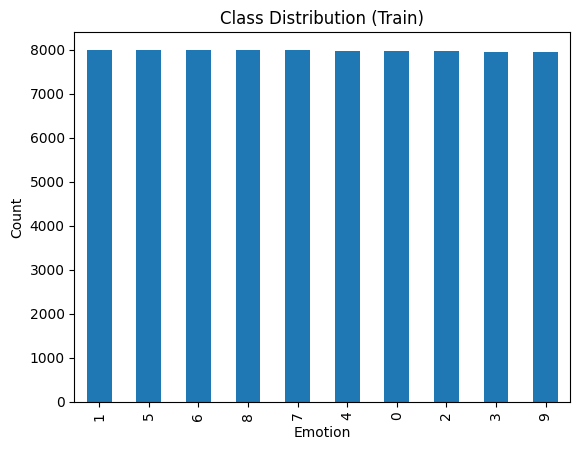

emotion
1    7997
5    7996
6    7993
8    7991
7    7984
4    7982
0    7980
2    7975
3    7958
9    7940
Name: count, dtype: int64


In [8]:
#eda- class distribution
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.DataFrame(dataset["train"])

counts = train_df["emotion"].value_counts()

plt.figure()
counts.plot(kind="bar")
plt.title("Class Distribution (Train)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

print(counts)


### Observations from EDA and comments on class imbalance

The class distribution across the 10 emotion categories is nearly uniform,
with each class containing approximately 7,940–7,997 samples.
The difference between the smallest and largest class is minimal,
indicating no significant class imbalance.
Weighted F1-score is still reported to ensure robust evaluation.



In [9]:
#tokeniser
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 128


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
import torch
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, split):
        self.texts = dataset[split]["sentence"]
        self.labels = dataset[split]["emotion"]  # Already numeric!

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(self.labels[idx])
        }


In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(EmotionDataset("train"), batch_size=16, shuffle=True)
val_loader = DataLoader(EmotionDataset("validation"), batch_size=16)
test_loader = DataLoader(EmotionDataset("test"), batch_size=16)


In [12]:
from transformers import AutoModel
import torch.nn as nn

class EmotionClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.fc(self.dropout(pooled))


In [13]:
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmotionClassifier(num_classes).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

EPOCHS = 5
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [14]:
print(model)

EmotionClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [15]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

best_val_acc = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # ----- VALIDATION -----
    model.eval()
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, mask)
            preds = torch.argmax(outputs, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_true, val_preds)

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")

100%|██████████| 4988/4988 [33:07<00:00,  2.51it/s]


Epoch 1
Train Loss: 0.3022
Validation Accuracy: 0.9562


100%|██████████| 4988/4988 [33:13<00:00,  2.50it/s]


Epoch 2
Train Loss: 0.0909
Validation Accuracy: 0.9641


100%|██████████| 4988/4988 [33:13<00:00,  2.50it/s]


Epoch 3
Train Loss: 0.0485
Validation Accuracy: 0.9669


100%|██████████| 4988/4988 [33:12<00:00,  2.50it/s]


Epoch 4
Train Loss: 0.0258
Validation Accuracy: 0.9667


100%|██████████| 4988/4988 [33:12<00:00,  2.50it/s]


Epoch 5
Train Loss: 0.0138
Validation Accuracy: 0.9689


In [16]:
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [17]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

model.eval()
preds = []
true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, mask)
        predictions = torch.argmax(outputs, dim=1)

        preds.extend(predictions.cpu().numpy())
        true.extend(labels.cpu().numpy())

acc = accuracy_score(true, preds)
precision, recall, f1, _ = precision_recall_fscore_support(true, preds, average="weighted")

print("Test Accuracy:", acc)
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)
print("F1 Score (weighted):", f1)

Test Accuracy: 0.9669172932330827
Precision (weighted): 0.9670695836352268
Recall (weighted): 0.9669172932330827
F1 Score (weighted): 0.9669370269910583


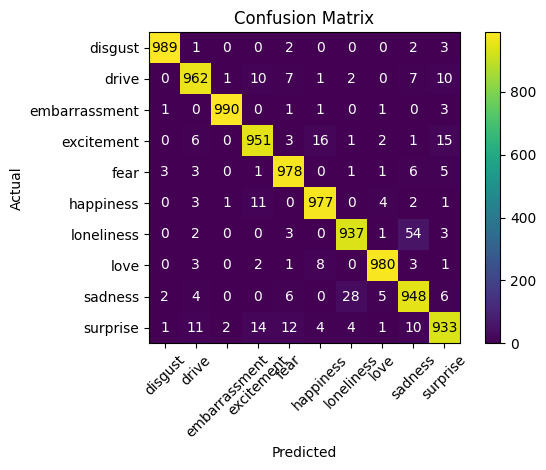

In [18]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(true, preds)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(range(num_classes), label_names, rotation=45)
plt.yticks(range(num_classes), label_names)
plt.colorbar()

# Write values in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="black" if cm[i, j] > cm.max() / 2 else "white"
        )

plt.tight_layout()
plt.show()


In [19]:
import torch.nn.functional as F

def predict_text(text):
    model.eval()

    encoding = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=MAX_LEN
    )

    input_ids = encoding["input_ids"].to(device)
    mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, mask)
        probs = F.softmax(outputs, dim=1)
        confidence, pred = torch.max(probs, dim=1)

    return label_names[pred.item()], confidence.item()

In [20]:
examples = [
    "I feel amazing today!",
    "I am scared of tomorrow's results",
    "Nobody talks to me anymore",
    "That was shocking!",
    "I love my best friends"
]

for text in examples:
    label, conf = predict_text(text)
    print(f"{text} --> {label} ({conf:.3f})")

I feel amazing today! --> happiness (0.999)
I am scared of tomorrow's results --> fear (0.999)
Nobody talks to me anymore --> loneliness (0.999)
That was shocking! --> surprise (1.000)
I love my best friends --> happiness (0.975)
